In [1]:
import os, subprocess
import json
import uproot
import awkward as ak
import numpy as np
from coffea import processor, util, hist
import pandas as pd
import pickle

#Plot settings
%matplotlib inline
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
#mpl.rcParams['lines.linewidth'] = 5

#Dataset parameters
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

with open('../../files/xsec.json') as f:
    xs = json.load(f)

with open('../../files/pmap.json') as f:
    pmap = json.load(f)

systematics = ['nominal',
               'jet_triggerUp','jet_triggerDown',
               'btagWeightUp','btagWeightDown','btagEffStatUp','btagEffStatDown',
               'UESUp','UESDown','JESUp','JESDown','JERUp','JERDown',
              ]

In [15]:
ParticleNet_WorkingPoints = {
        '2016APV_bb':    [0.0, 0.9088, 0.9737, 0.9883],
        '2016APV_cc':    [0.0, 0.9252, 0.9751, 0.9909],
        
        '2016_bb': [0.0, 0.9137, 0.9735, 0.9883],
        '2016_cc': [0.0, 0.9252, 0.9743, 0.9905],
        
        '2017_bb':    [0.0, 0.9105, 0.9714, 0.9870],
        '2017_cc':    [0.0, 0.9347, 0.9765, 0.9909],
        
        '2018_bb':    [0.0, 0.9172, 0.9734, 0.9880],
        '2018_cc':    [0.0, 0.9368, 0.9777, 0.9917]
}

In [22]:
#Define the year here
year = '2017'

## Get significance from combine scan

In [2]:
#Open one file and extract the thresholds and significance
def open_file_and_extract(file_path):
    
    thresholds_temp = []
    thresholds = []
    significance = []
    status = []
    
    with open(file_path) as f:
        lines = f.read().splitlines()
        
    for x in lines:
        
        if x.endswith('>>>') and not x.startswith('>>>'):
            thresholds_temp.append([float(y[5:]) for y in x[:-4].split(';')])
            
        if x.startswith('Significance:'):            
            significance.append(float(x[14:]))
            thresholds.append(thresholds_temp[-1])
            
        if x.startswith('INFO: (function: improveOnce) CascadeMinimizer.cc: 211 -- Minimisation finished with status=-1'): status.append(-1)
        if x.startswith('INFO: (function: improveOnce) CascadeMinimizer.cc: 211 -- Minimisation finished with status=0'): status.append(0)
        
    
    for i in range(len(significance)):
        if status[2*i] + status[2*i+1]< 0:
            significance[i] = -1
        
#     print("Thresholds: {}. Length: {}".format(thresholds,len(thresholds)))
#     print("Significance: ", significance)
#     print("Status: {}. Length: {}".format(status, len(status)))
    
    return thresholds, significance, status
    
def scan_logs_out(log_dir):
    
    ddb_thres = []
    ddc_thres = []
    all_sign = []
    all_status = []
    
    #Loop over the files
    for file in os.listdir(log_dir):
        
        filename = os.fsdecode(file)
        if filename.endswith(".out"):
            local_thres, local_sign, local_status = open_file_and_extract(os.path.join(log_dir,filename))
            
            if len(local_sign) > 0:
                    ddb_thres += [x[0] for x in local_thres]
                    ddc_thres += [x[1] for x in local_thres]
                    all_sign += local_sign
                    all_status += local_status
#             elif len(local_sign) < 10:
#                 print("local thres:", local_thres)
#                 print("Local sign: ", local_sign)
                
    return np.asarray(ddb_thres), np.asarray(ddc_thres), np.asarray(all_sign), np.asarray(all_status)
            
ddb, ddc, sign, status = scan_logs_out("logs/")

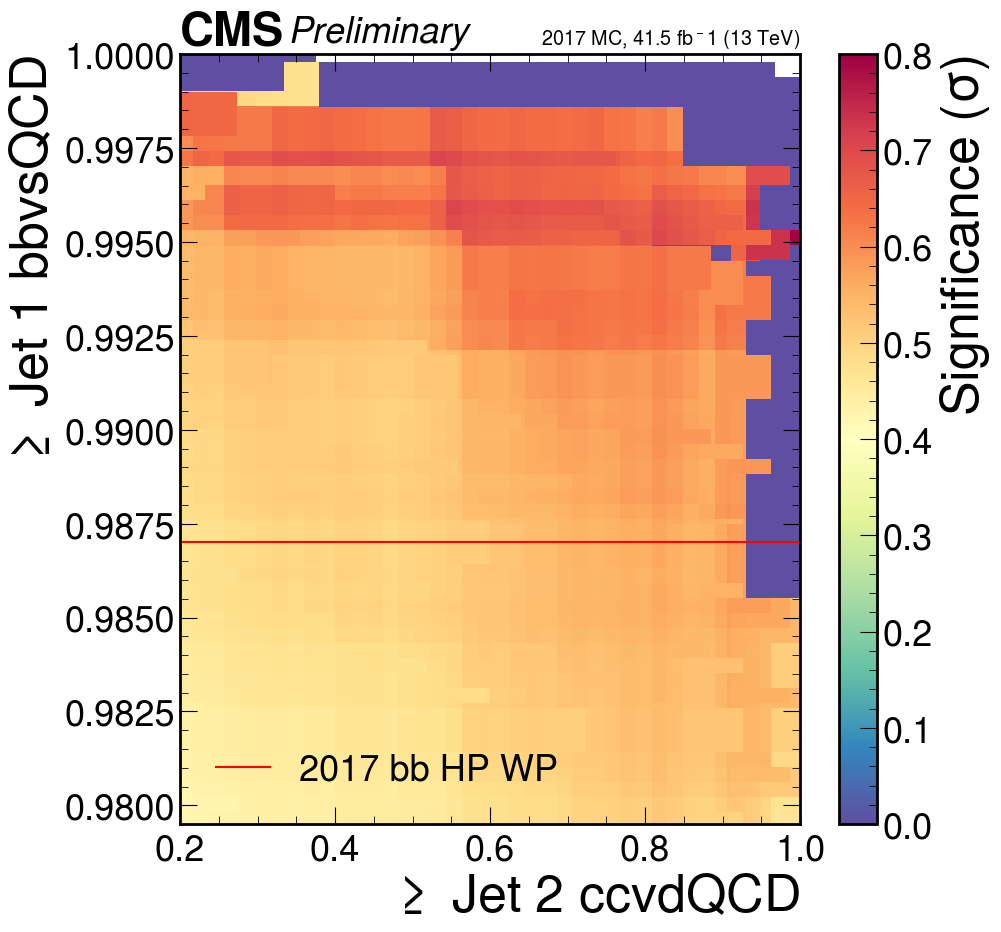

In [53]:
fig, ax = plt.subplots()
im = ax.scatter(ddc, ddb, c=sign, s=1000, marker='s', cmap='Spectral_r',linewidths=0, vmin=0, vmax=0.8)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'Significance ($\sigma$)')

hep.cms.text("Preliminary")
hep.cms.lumitext(f"{year} MC, {lumis[year]} $fb^{-1}$ (13 TeV)", fontsize=15)

plt.xlabel(r"$\geq$ Jet 2 ccvdQCD")
plt.ylabel(r"$\geq$ Jet 1 bbvsQCD")
plt.xlim([0.2,1])
plt.ylim([0.9795,1])
WP = plt.axhline(y=ParticleNet_WorkingPoints[f'{year}_bb'][3],
            color='r',
            linestyle='-',
            label=f'{year} HP WP')

plt.legend([WP], [f'{year} bb HP WP'], loc = 'lower left')
#plt.xscale('log')

##### d = {'Jet 1 b': ddb, 'Jet 2 c': ddc, 'significance':sign}
df = pd.DataFrame(data=d)

##### df['significance']

In [38]:
df_print.iloc[0]['Jet 1 b']

0.99265

In [68]:
df_print = df[(df['significance'] > 0.66) & (df['Jet 1 b'] > 0.996)]

for i in range(len(df_print)):
    print("---------")
    print("B Threshold: ",df_print.iloc[i]['Jet 1 b'])
    print("C Threshold: ", df_print.iloc[i]['Jet 2 c'])
    print("Significance: ", df_print.iloc[i]['significance'])

---------
B Threshold:  0.9988
C Threshold:  0.9909
Significance:  189737.0
---------
B Threshold:  0.9984
C Threshold:  0.551
Significance:  0.683657
---------
B Threshold:  0.9984
C Threshold:  0.5714
Significance:  0.676681
---------
B Threshold:  0.9984
C Threshold:  0.5918
Significance:  0.66372
---------
B Threshold:  0.9963
C Threshold:  0.5714
Significance:  0.704848
---------
B Threshold:  0.9963
C Threshold:  0.5918
Significance:  0.695519
---------
B Threshold:  0.9963
C Threshold:  0.6122
Significance:  0.690554
---------
B Threshold:  0.9963
C Threshold:  0.6327
Significance:  0.686787
---------
B Threshold:  0.9963
C Threshold:  0.6531
Significance:  0.69087
---------
B Threshold:  0.9963
C Threshold:  0.6735
Significance:  0.690622
---------
B Threshold:  0.9963
C Threshold:  0.6939
Significance:  0.68332
---------
B Threshold:  0.9963
C Threshold:  0.7143
Significance:  0.684925
---------
B Threshold:  0.9963
C Threshold:  0.7347
Significance:  0.684171
---------
B Thre

###### df_print = df[(df['significance'] > 0.55)]

for i in range(len(df_print)):
    print("---------")
    print("B Threshold: ",df_print.iloc[i]['Jet 1 b'])
    print("C Threshold: ", df_print.iloc[i]['Jet 2 c'])
    print("Significance: ", df_print.iloc[i]['significance'])

##### Define the working points (for 2017 only)
Xbb_points = [0.9105, 0.9714, 0.9870]
Xcc_points = [0.9347, 0.9765, 0.9909]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


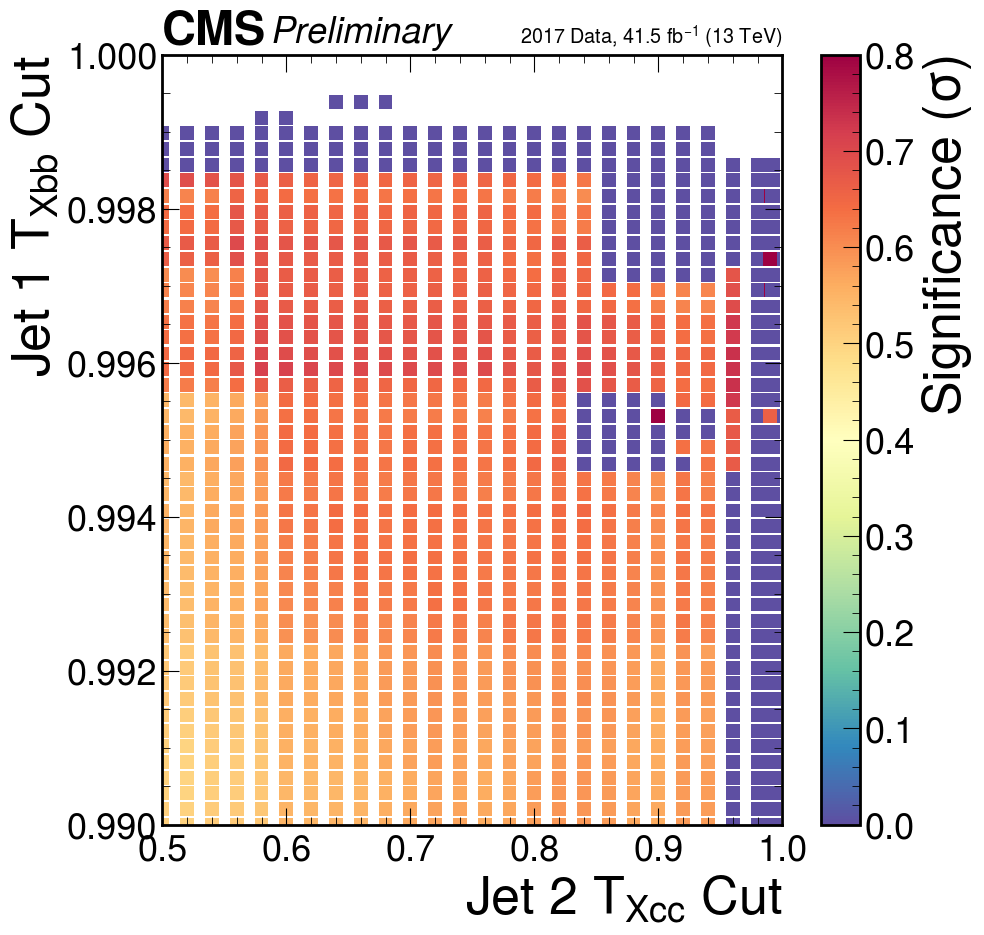

In [10]:
fig, ax = plt.subplots()
im = ax.scatter(ddc, ddb, c=sign, s=100, marker='s', cmap='Spectral_r',linewidths=0, vmin=0., vmax=0.8)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'Significance ($\sigma$)')

#Plot the working points
# legend_count = 0

# for Xbb in Xbb_points:
#     for Xcc in Xcc_points:
#         if legend_count == 0:
#             plt.scatter(Xcc, Xbb, s=600, marker='*',
#                         color ='firebrick', label = r"Working points")
#         else:
#             plt.scatter(Xcc, Xbb, s=600, marker='*',
#                         color ='firebrick')
#         legend_count += 1

hep.cms.text("Preliminary")
hep.cms.lumitext(r"2017 Data, 41.5 $fb^{-1}$ (13 TeV)", fontsize=15)

plt.xlabel(r"Jet 2 $T_{Xcc}$ Cut")
plt.ylabel(r"Jet 1 $T_{Xbb}$ Cut")
plt.xlim([0.5,1])
plt.ylim(0.99,1)
plt.legend(loc='best')
#plt.xscale('log')